In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =========================================================
# SYSTEM CHECK
# =========================================================
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow Version: 2.20.0
GPU Available: True


In [22]:
# =========================================================
# CONFIGURATION
# =========================================================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

PUBLIC_DIR = "../Dataset/preprocessed_Public"
SELF_DIR = "../Dataset/preprocessed_self"

CLASS_NAMES = sorted(os.listdir(PUBLIC_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)


Classes: ['test', 'train', 'val']


In [23]:
# =========================================================
# CLASS NAMES
# =========================================================
CLASS_NAMES = sorted([
    d for d in os.listdir(os.path.join(PUBLIC_DIR, "train"))
    if os.path.isdir(os.path.join(PUBLIC_DIR, "train", d))
])

NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)

Classes: ['aluminium', 'paper', 'plastic']


In [24]:
# =========================================================
# DATA GENERATORS 
# =========================================================
train_datagen = ImageDataGenerator(
    rescale=1./255   # Only normalization
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [25]:
# =========================================================
# LOAD DATA FROM DIRECTORIES
# =========================================================
train_gen = train_datagen.flow_from_directory(
    os.path.join(PUBLIC_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(PUBLIC_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(SELF_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\n📊 Dataset Summary")
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples (self):", test_gen.samples)

Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

📊 Dataset Summary
Train samples: 7512
Validation samples: 403
Test samples (self): 533


In [26]:
# =========================================================
# CNN MODEL (MEMORY SAFE)
# =========================================================
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

print("\n📋 Model Summary")
model.summary()



📋 Model Summary


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,043 (433.76 KB)

 Trainable params: 110,595 (432.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
# =========================================================
# CALLBACKS
# =========================================================
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4)
]


In [28]:
# =========================================================
# TRAINING
# =========================================================
print("\n🚀 Training started...\n")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Training started...

Epoch 1/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - accuracy: 0.5805 - loss: 0.8896 - precision: 0.6420 - recall: 0.4562 - val_accuracy: 0.5881 - val_loss: 0.8482 - val_precision: 0.6983 - val_recall: 0.4194 - learning_rate: 1.0000e-04
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.6709 - loss: 0.7428 - precision: 0.7399 - recall: 0.5580 - val_accuracy: 0.6998 - val_loss: 0.6766 - val_precision: 0.7692 - val_recall: 0.5955 - learning_rate: 1.0000e-04
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.6962 - loss: 0.6996 - precision: 0.7584 - recall: 0.5949 - val_accuracy: 0.6079 - val_loss: 0.8236 - val_precision: 0.6412 - val_recall: 0.5633 - learning_rate: 1.0000e-04
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7216 - loss: 0.6549 - precision: 0.7724 - recall: 0.6317 - val_accuracy: 0.6973 - val_loss: 0.6093 - val_precision: 0.7500 - val_recall: 0.6328 - learning_rate: 1.0000e-04
Epoch 5/50
470/4

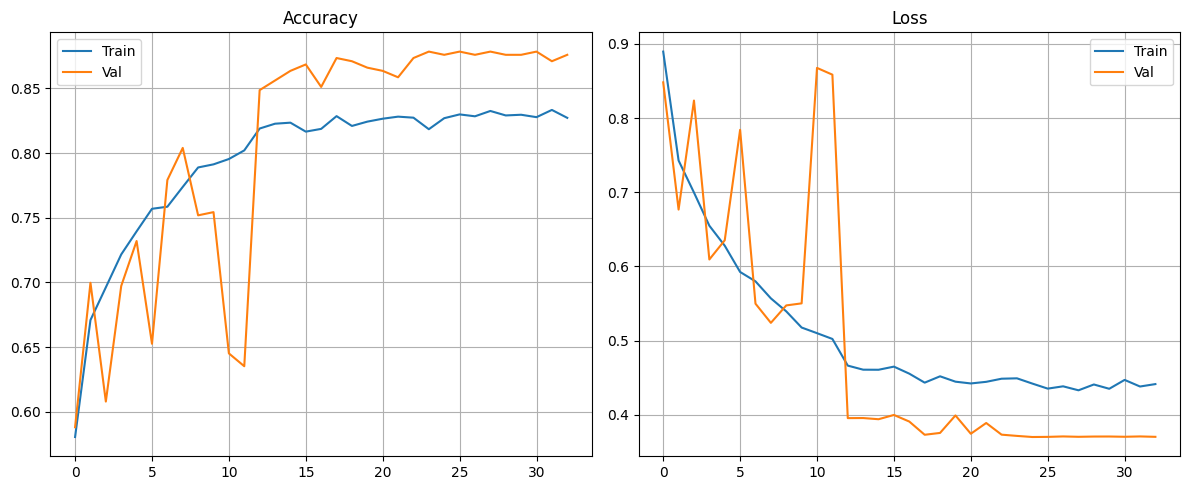

In [29]:
# =========================================================
# TRAINING CURVES
# =========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


📊 Evaluating on SELF-COLLECTED dataset...
Test Accuracy: 42.96%
Test Precision: 44.34%
Test Recall: 36.77%
Test F1-score: 40.21%
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step

📋 Classification Report
              precision    recall  f1-score   support

   aluminium       0.60      0.28      0.38       148
       paper       0.32      0.34      0.33       151
     plastic       0.45      0.59      0.51       234

    accuracy                           0.43       533
   macro avg       0.46      0.40      0.41       533
weighted avg       0.45      0.43      0.42       533



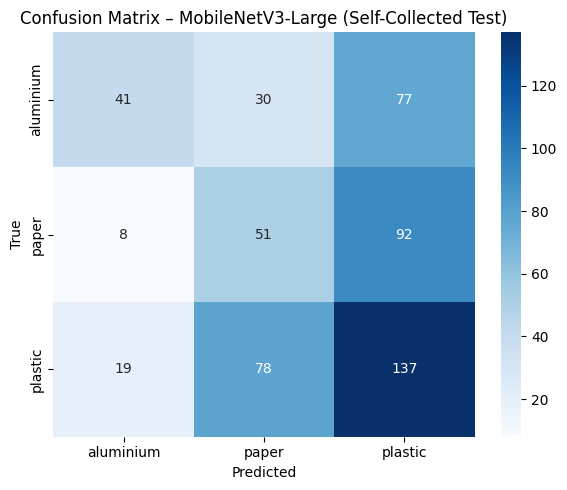

✅ Evaluation completed


In [32]:
# ============================
# EVALUATION ON SELF-COLLECTED DATA
# ============================


print("\n📊 Evaluating on SELF-COLLECTED dataset...")


test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall: {test_rec*100:.2f}%")
print(f"Test F1-score: {test_f1*100:.2f}%")


# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


# Classification report
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_gen.class_indices.keys(),
yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix – MobileNetV3-Large (Self-Collected Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


print("✅ Evaluation completed")